In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time


In [3]:
# 网格世界环境
class GridWorld:
    def __init__(self, agent_position=(0, 0), goal_position=(4, 4), width=5, height=5):
        self.width = width
        self.height = height
        self.agent_position = agent_position  # 初始位置：左上角
        self.goal_position = goal_position  # 目标位置：右下角
        self.obstacles = [(1, 1), (2, 2), (3, 1)]  # 障碍物位置
        
        # 定义动作 (上, 右, 下, 左)
        self.actions = [(-1, 0), (0, 1), (1, 0), (0, -1)]
        self.action_names = ["上", "右", "下", "左"]
        
    def reset(self):
        self.agent_position = (0, 0)
        return self.agent_position
    
    def is_valid_position(self, position):
        x, y = position
        return (0 <= x < self.width and 
                0 <= y < self.height and 
                position not in self.obstacles)
    
    def step(self, action_idx):
        action = self.actions[action_idx]
        
        # 计算新位置
        new_position = (self.agent_position[0] + action[0], 
                        self.agent_position[1] + action[1])
        
        # 检查是否是有效位置
        if self.is_valid_position(new_position):
            self.agent_position = new_position
            
        # 计算奖励和是否终止
        if self.agent_position == self.goal_position:
            reward = 100  # 达到目标的奖励
            done = True
        else:
            reward = -1  # 每一步的惩罚，鼓励找到最短路径
            done = False
            
        return self.agent_position, reward, done
    
    def render(self, q_table=None):
        grid = [['□' for _ in range(self.width)] for _ in range(self.height)]
        
        # 放置障碍物
        for obs in self.obstacles:
            grid[obs[0]][obs[1]] = '■'
        
        # 放置目标
        grid[self.goal_position[0]][self.goal_position[1]] = '★'
        
        # 放置智能体
        grid[self.agent_position[0]][self.agent_position[1]] = '○'
        
        # 可视化Q值（可选）
        if q_table is not None:
            print("当前位置的 Q(s,a) 值：")
            state = self.agent_position
            for i, action_name in enumerate(self.action_names):
                print(f"{action_name}: {q_table[state[0], state[1], i]:.2f}", end=", ")
            print()
                
        # 打印网格
        for row in grid:
            print(' '.join(row))
        print()

    def visualize_policy(self, q_table):
        policy_grid = [['□' for _ in range(self.width)] for _ in range(self.height)]
        
        # 放置障碍物
        for obs in self.obstacles:
            policy_grid[obs[0]][obs[1]] = '■'
        
        # 放置目标
        policy_grid[self.goal_position[0]][self.goal_position[1]] = '★'
        
        # 为每个状态显示最佳动作
        direction_symbols = ['↑', '→', '↓', '←']
        
        for i in range(self.height):
            for j in range(self.width):
                if (i, j) not in self.obstacles and (i, j) != self.goal_position:
                    # 获取最佳动作
                    best_action = np.argmax(q_table[i, j])
                    policy_grid[i][j] = direction_symbols[best_action]
        
        # 打印策略网格
        print("最优策略：")
        for row in policy_grid:
            print(' '.join(row))
        print()
        


In [4]:
class QLearning:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1):
        self.env = env
        self.alpha = alpha      # 学习率
        self.gamma = gamma      # 折扣因子
        self.epsilon = epsilon  # 探索率
        
        # 初始化Q表 - 状态为(x, y)，动作为0-3
        self.q_table = np.zeros((env.width, env.height, len(env.actions)))
    
    def choose_action(self, state):
        # 使用ε-greedy策略选择动作
        if random.random() < self.epsilon:
            # 四个action中随机选择一个作为下一个action，展示exploration的思路
            return random.randint(0, len(self.env.actions) - 1)  # 探索：随机选择
        else:
            # state[0], state[1]代表了当前的状态，用该状态去Q表中检索
            return np.argmax(self.q_table[state[0], state[1]])   # 利用：选择最大Q值
    
    def train(self, episodes=1000):
        rewards_history = []
        steps_history = []
        
        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0
            steps = 0
            done = False
            
            while not done:
                # 选择动作
                action = self.choose_action(state)
                
                # 执行动作，观察下一个状态和奖励
                next_state, reward, done = self.env.step(action)
                total_reward += reward
                steps += 1
                
                # Q-learning更新
                current_q = self.q_table[state[0], state[1], action]
                
                # Q-learning使用下一状态的最大Q值，而不是下一个选择动作的Q值
                # 这是Q-learning和SARSA之间的关键区别
                next_max_q = np.max(self.q_table[next_state[0], next_state[1]])
                
                # Q(s,a) ← Q(s,a) + α[r + γ·max_a' Q(s',a') - Q(s,a)]
                self.q_table[state[0], state[1], action] = \
                    current_q + self.alpha * (reward + self.gamma * next_max_q - current_q)
                
                # 更新状态
                state = next_state
            
            rewards_history.append(total_reward)
            steps_history.append(steps)
            
            if (episode + 1) % 10 == 0:
                print(f"回合 {episode + 1}/{episodes}, 平均奖励: {np.mean(rewards_history[-100:]):.2f}, 平均步数: {np.mean(steps_history[-100:]):.2f}")
        
        return rewards_history, steps_history
    
    def evaluate(self, render=True):
        state = self.env.reset()
        done = False
        total_reward = 0
        steps = 0
        
        if render:
            print("评估模式 - 展示学习到的策略:")
            self.env.render(self.q_table)
            time.sleep(1)
        
        while not done:
            # 选择最优动作（不再探索）
            action = np.argmax(self.q_table[state[0], state[1]])
            
            # 执行动作
            next_state, reward, done = self.env.step(action)
            total_reward += reward
            steps += 1
            state = next_state
            
            if render:
                self.env.render(self.q_table)
                time.sleep(1)
        
        if render:
            print(f"评估完成 - 总奖励: {total_reward}, 总步数: {steps}")
        
        return total_reward, steps
    
    def visualize_policy(self):
        """可视化学习到的策略"""
        policy_grid = [['□' for _ in range(self.env.width)] for _ in range(self.env.height)]
        
        # 放置障碍物
        for obs in self.env.obstacles:
            policy_grid[obs[0]][obs[1]] = '■'
        
        # 放置目标
        policy_grid[self.env.goal_position[0]][self.env.goal_position[1]] = '★'
        
        # 为每个状态显示最佳动作
        direction_symbols = ['↑', '→', '↓', '←']
        
        for i in range(self.env.height):
            for j in range(self.env.width):
                if (i, j) not in self.env.obstacles and (i, j) != self.env.goal_position:
                    # 获取最佳动作
                    best_action = np.argmax(self.q_table[i, j])
                    policy_grid[i][j] = direction_symbols[best_action]
        
        # 打印策略网格
        print("Q-learning 最优策略：")
        for row in policy_grid:
            print(' '.join(row))
        print()

In [5]:
# 可视化学习进度
def plot_learning(rewards, steps):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(rewards)
    plt.title('reward per episode')
    plt.xlabel('episode number')
    plt.ylabel('cumulative reward')
    
    plt.subplot(1, 2, 2)
    plt.plot(steps)
    plt.title('steps per episode')
    plt.xlabel('episode number')
    plt.ylabel('step number')
    
    plt.tight_layout()
    plt.show()

开始训练...
回合 10/100, 平均奖励: 47.50, 平均步数: 53.50
回合 20/100, 平均奖励: 61.95, 平均步数: 39.05
回合 30/100, 平均奖励: 69.40, 平均步数: 31.60
回合 40/100, 平均奖励: 73.95, 平均步数: 27.05
回合 50/100, 平均奖励: 77.46, 平均步数: 23.54
回合 60/100, 平均奖励: 79.95, 平均步数: 21.05
回合 70/100, 平均奖励: 81.67, 平均步数: 19.33
回合 80/100, 平均奖励: 83.03, 平均步数: 17.98
回合 90/100, 平均奖励: 84.06, 平均步数: 16.94
回合 100/100, 平均奖励: 84.85, 平均步数: 16.15


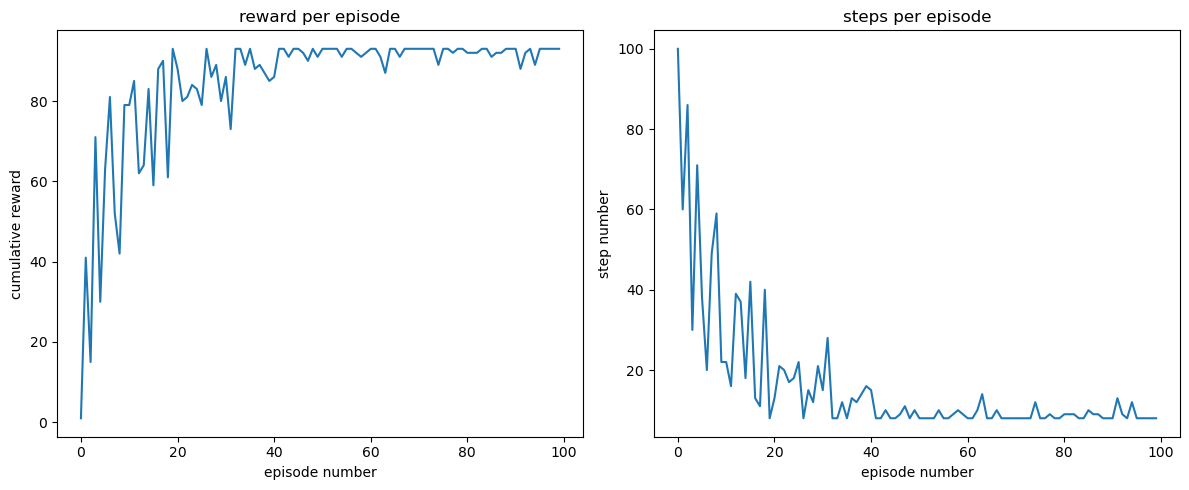

评估模式 - 展示学习到的策略:
当前位置的 Q(s,a) 值：
上: -1.86, 右: 22.48, 下: -2.77, 左: -1.75, 
○ □ □ □ □
□ ■ □ □ □
□ □ ■ □ □
□ ■ □ □ □
□ □ □ □ ★

当前位置的 Q(s,a) 值：
上: -2.20, 右: 33.46, 下: 1.99, 左: -0.21, 
□ ○ □ □ □
□ ■ □ □ □
□ □ ■ □ □
□ ■ □ □ □
□ □ □ □ ★

当前位置的 Q(s,a) 值：
上: 0.92, 右: 45.29, 下: -1.39, 左: -1.20, 
□ □ ○ □ □
□ ■ □ □ □
□ □ ■ □ □
□ ■ □ □ □
□ □ □ □ ★

当前位置的 Q(s,a) 值：
上: 13.68, 右: -0.96, 下: 56.31, 左: 2.73, 
□ □ □ ○ □
□ ■ □ □ □
□ □ ■ □ □
□ ■ □ □ □
□ □ □ □ ★

当前位置的 Q(s,a) 值：
上: 2.93, 右: 0.02, 下: 67.41, 左: -0.71, 
□ □ □ □ □
□ ■ □ ○ □
□ □ ■ □ □
□ ■ □ □ □
□ □ □ □ ★

当前位置的 Q(s,a) 值：
上: 9.88, 右: 4.56, 下: 78.04, 左: 9.26, 
□ □ □ □ □
□ ■ □ □ □
□ □ ■ ○ □
□ ■ □ □ □
□ □ □ □ ★

当前位置的 Q(s,a) 值：
上: 9.52, 右: 88.78, 下: 13.83, 左: -0.10, 
□ □ □ □ □
□ ■ □ □ □
□ □ ■ □ □
□ ■ □ ○ □
□ □ □ □ ★

当前位置的 Q(s,a) 值：
上: -0.10, 右: 7.72, 下: 99.98, 左: 7.78, 
□ □ □ □ □
□ ■ □ □ □
□ □ ■ □ □
□ ■ □ □ ○
□ □ □ □ ★

当前位置的 Q(s,a) 值：
上: 0.00, 右: 0.00, 下: 0.00, 左: 0.00, 
□ □ □ □ □
□ ■ □ □ □
□ □ ■ □ □
□ ■ □ □ □
□ □ □ □ ○

评估完成 - 总奖励: 93, 总步数: 8

学习

In [6]:
# 主函数
def main():
    # 创建环境和智能体
    env = GridWorld(width=5, height=5)
    q_learning_agent = QLearning(env, alpha=0.1, gamma=0.9, epsilon=0.1)
    
    # 训练
    print("开始训练...")
    rewards, steps = q_learning_agent.train(episodes=100)
    
    # 绘制学习曲线
    plot_learning(rewards, steps)
    
    # 评估
    q_learning_agent.evaluate(render=True)
    
    # 显示学习到的策略
    print("\n学习到的策略 (最优动作):")
    for i in range(env.width):
        for j in range(env.height):
            if (i, j) in env.obstacles:
                print("■", end="\t")
            elif (i, j) == env.goal_position:
                print("★", end="\t")
            else:
                best_action = np.argmax(q_learning_agent.q_table[i, j])
                print(env.action_names[best_action], end="\t")
        print()

if __name__ == "__main__":
    main()

In [7]:
# 比较 Q-learning 和 SARSA
def compare_algorithms(env, episodes=500):
    # 训练 Q-learning
    print("训练 Q-learning 算法...")
    q_table, q_rewards, q_steps = q_learning(env, episodes)
    
    # 显示 Q-learning 的最优策略
    env.visualize_policy(q_table)
    
    # 重置环境
    env = GridWorld()
    
    # 训练 SARSA
    print("\n训练 SARSA 算法...")
    sarsa_table, sarsa_rewards, sarsa_steps = sarsa(env, episodes)
    
    # 显示 SARSA 的最优策略
    env.visualize_policy(sarsa_table)
    
    # 绘制学习曲线
    plt.figure(figsize=(12, 5))
    
    # 平滑化奖励曲线
    def smooth(data, window=10):
        return [sum(data[max(0, i-window):i])/min(i, window) for i in range(1, len(data)+1)]
    
    smooth_q_rewards = smooth(q_rewards)
    smooth_sarsa_rewards = smooth(sarsa_rewards)
    
    # 绘制奖励曲线
    plt.subplot(1, 2, 1)
    plt.plot(smooth_q_rewards, label='Q-learning')
    plt.plot(smooth_sarsa_rewards, label='SARSA')
    plt.xlabel('回合')
    plt.ylabel('平均奖励')
    plt.title('奖励曲线')
    plt.legend()
    
    # 绘制步数曲线
    plt.subplot(1, 2, 2)
    plt.plot(smooth(q_steps), label='Q-learning')
    plt.plot(smooth(sarsa_steps), label='SARSA')
    plt.xlabel('回合')
    plt.ylabel('平均步数')
    plt.title('步数曲线')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('algorithm_comparison.png')
    plt.show()
    
    print("学习曲线已保存为 algorithm_comparison.png")
    
    # 测试最优策略的性能
    def test_policy(env, q_table, n_episodes=100):
        total_rewards = 0
        total_steps = 0
        success_count = 0
        
        for _ in range(n_episodes):
            state = env.reset()
            done = False
            episode_reward = 0
            steps = 0
            
            while not done and steps < 100:
                # 根据策略选择动作
                action = np.argmax(q_table[state[0], state[1]])
                state, reward, done = env.step(action)
                episode_reward += reward
                steps += 1
                
                if done and reward == 100:  # 成功到达目标
                    success_count += 1
            
            total_rewards += episode_reward
            total_steps += steps
        
        avg_reward = total_rewards / n_episodes
        avg_steps = total_steps / n_episodes
        success_rate = success_count / n_episodes
        
        return avg_reward, avg_steps, success_rate
    
    # 测试 Q-learning 和 SARSA 的性能
    q_avg_reward, q_avg_steps, q_success_rate = test_policy(GridWorld(), q_table)
    sarsa_avg_reward, sarsa_avg_steps, sarsa_success_rate = test_policy(GridWorld(), sarsa_table)
    
    print("\n性能评估结果:")
    print(f"Q-learning - 平均奖励: {q_avg_reward:.2f}, 平均步数: {q_avg_steps:.2f}, 成功率: {q_success_rate:.2%}")
    print(f"SARSA - 平均奖励: {sarsa_avg_reward:.2f}, 平均步数: {sarsa_avg_steps:.2f}, 成功率: {sarsa_success_rate:.2%}")
    
    return q_table, sarsa_table

# 运行示例
if __name__ == "__main__":
    # 创建环境
    env = GridWorld()
    
    # 比较 Q-learning 和 SARSA
    q_table, sarsa_table = compare_algorithms(env, episodes=500)
    
    # 演示 Q-learning 策略
    print("\n演示 Q-learning 最优策略:")
    env = GridWorld()
    state = env.reset()
    env.render(q_table)
    
    # 最多走20步
    for _ in range(20):
        action = np.argmax(q_table[state[0], state[1]])
        state, reward, done = env.step(action)
        env.render(q_table)
        
        if done:
            print("目标达成!")
            break

训练 Q-learning 算法...


NameError: name 'q_learning' is not defined